## **Importing the Image data from Google drive**

**Note:** we figured out how to download a nested folder structure allong with the files from Google Drive (instead of just one file) from the following StackOverflow discussion - https://stackoverflow.com/questions/46155300/pydrive-error-no-downloadlink-exportlinks-for-mimetype-found-in-metadata

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# f = open("failed.txt","w+")
# folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac'
# # Note: these folders should match the final project folder structure we create and may need to be updated
# root = '../../data/raw'
# # If the folders that we want to download the images to do not exit then create them as shown below:
# # os.mkdir('../../data')
# # os.mkdir('../../data/raw')

f = open("failed.txt","w+")
folder_id = '...' # from the last slash ('/') till the '?'
os.mkdir('data')
root = './data/raw'
os.mkdir(root)

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

search_folder(folder_id,root+'/')
f.close()

Creating folder: ./data/raw/bag
Creating folder: ./data/raw/bag/bag_2_inside
Creating folder: ./data/raw/bag/bag_0_front
Creating folder: ./data/raw/bag/bag_1_side
Creating folder: ./data/raw/bag/bag_4_look
Creating folder: ./data/raw/bag/bag_3_back


## **Visualize the directory structure we created above and some of the images:**

**Note:** there is a script we can run to find corrupted images. We ran this script and found an image (./image_data/raw/clothes/clothes_1_zoomed/32760559-001.jpg') that was corrupted and deleted it from the directory so it does not cause issues down stream when we train our models

In [3]:
import pathlib
data_dir = pathlib.Path(root)
data_dir

PosixPath('data/raw')

In [4]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (94.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121730 files and directories currently instal

In [5]:
!tree --dirsfirst --filelimit 6 './image_data/raw'

./image_data/raw  [error opening dir]

0 directories, 0 files


In [6]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 124


In [7]:
# clothes_0_model_front = list(data_dir.glob('clothes/clothes_0_model_front/*.jpg')) # F

In [8]:
# PIL.Image.open(str(clothes_0_model_front[4])) # IndexError: list index out of range # F

IndexError: list index out of range

In [9]:
from struct import unpack
from tqdm import tqdm
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                raise TypeError("issue reading jpeg file")

bads = []

img_dir = root

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
        image = os.path.join(dirName,img)
        image = JPEG(image)
        try:
            image.decode()
        except:
            bads.append(dirName+'/'+img)

#Show the bad images
bads

#remove the bad images
# note: we found the following image that was corrupted that we removed - ./raw/clothes/clothes_1_zoomed/32760559-001.jpg'
# for name in bads:
#   os.remove(name)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 25/25 [00:00<00:00, 9267.95it/s]


[]

In [10]:
bads

[]

## Load the image files from the images directory and split the data in to Train, Validation and Test datasets

In [34]:
RANDOM_SEED = 42
VAL_SPLIT = 0.3             # VAL_SPLIT = 0.4
PRODUCT_CATEGORY = 'bags'   # PRODUCT_CATEGORY = 'clothes'
BATCH_SIZE = 32
IMG_SIZE = (427, 350)       # IMG_SIZE = (427, 350)
IMG_SHAPE = (427, 350, 3)   # IMG_SHAPE = (427, 350, 3)
SHUFFLE = True

PROD_DATA_DIR = pathlib.Path('./data/raw/bag') # PROD_DATA_DIR = pathlib.Path(root+'/'+PRODUCT_CATEGORY)
CLASSES = []
for item in os.scandir(PROD_DATA_DIR):
    if not item.name.startswith('.'): #dont include any hidden files or dirs that may be in the folder (more applicable when running on local machine)
        CLASSES.append(item.name)

In [35]:
CLASSES

['bag_3_back', 'bag_2_inside', 'bag_4_look', 'bag_0_front', 'bag_1_side']

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = PROD_DATA_DIR,
  validation_split=VAL_SPLIT,  # VAL_SPLIT = 0.4
  subset="training",
  seed=RANDOM_SEED,
  class_names=CLASSES,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle = SHUFFLE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = PROD_DATA_DIR,
  validation_split=VAL_SPLIT,  # VAL_SPLIT = 0.4
  subset="validation",
  seed=RANDOM_SEED,
  class_names=CLASSES,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle = SHUFFLE)

Found 124 files belonging to 5 classes.
Using 87 files for training.
Found 124 files belonging to 5 classes.
Using 37 files for validation.


In [37]:
image_count = len(list(data_dir.glob('clothes/*/*.jpg')))
print(image_count)

0


In [38]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)  # test_ds  # ((val_batches) // 2)
val_ds = val_ds.skip((2*val_batches) // 3)

In [39]:
#type(test_ds)
len(test_ds)

1

In [40]:
len(test_ds)*BATCH_SIZE

32

In [41]:
type(test_ds)

tensorflow.python.data.ops.take_op._TakeDataset

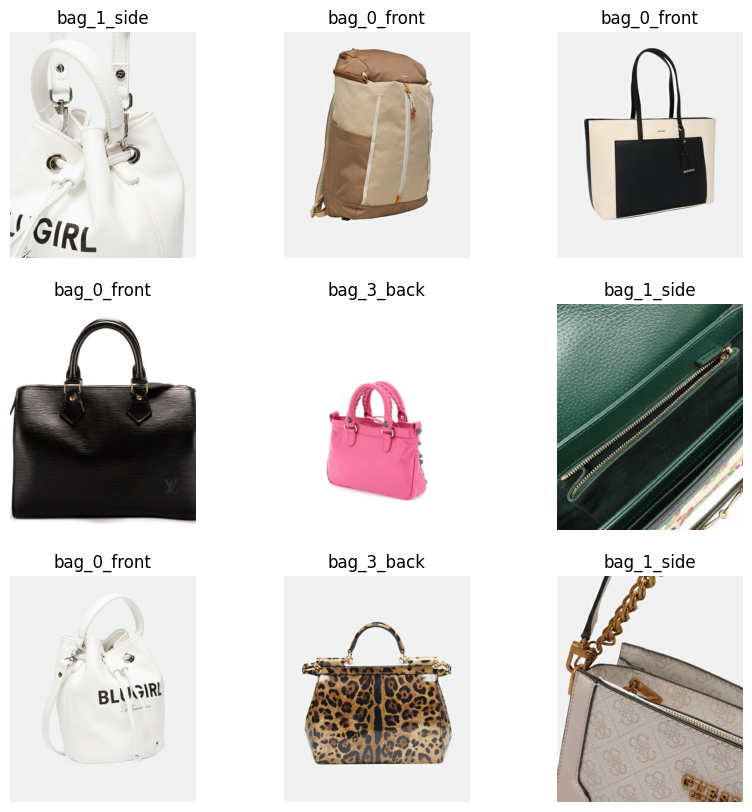

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Utility Functions**

In [44]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

## **Create and train the base CNN model**

In [45]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def create_base_model():
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),

      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(256, activation='relu'),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

In [46]:
model_base = create_base_model()
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [47]:
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 427, 350, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 427, 350, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 213, 175, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 213, 175, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 106, 87, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 87, 128)     

In [48]:
history_base = model_base.fit(
    x=train_ds,
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose="auto",
    # callbacks=None,
    # validation_split=0.3,
    # shuffle=True,
    validation_data=val_ds
    # class_weight=None,
    # sample_weight=None,
    # initial_epoch=0,
    # steps_per_epoch=None,
    # validation_steps=None,
    # validation_batch_size=None,
    # validation_freq=1,
)

Epoch 1/10
3/3 [==============================] - 7s 3s/step - loss: 3.0330 - accuracy: 0.2069 - val_loss: 2.7399 - val_accuracy: 0.2000
Epoch 2/10
3/3 [==============================] - 0s 147ms/step - loss: 1.8274 - accuracy: 0.1954 - val_loss: 1.5272 - val_accuracy: 0.2000
Epoch 3/10
3/3 [==============================] - 0s 149ms/step - loss: 1.5131 - accuracy: 0.3678 - val_loss: 1.5224 - val_accuracy: 0.2000
Epoch 4/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3045 - accuracy: 0.5057 - val_loss: 1.4127 - val_accuracy: 0.2000
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0730 - accuracy: 0.6322 - val_loss: 1.1096 - val_accuracy: 0.6000
Epoch 6/10
3/3 [==============================] - 0s 146ms/step - loss: 0.8761 - accuracy: 0.7471 - val_loss: 0.9359 - val_accuracy: 0.6000
Epoch 7/10
3/3 [==============================] - 0s 155ms/step - loss: 0.7719 - accuracy: 0.7471 - val_loss: 0.7432 - val_accuracy: 0.8000
Epoch 8/10
3/3 [=======

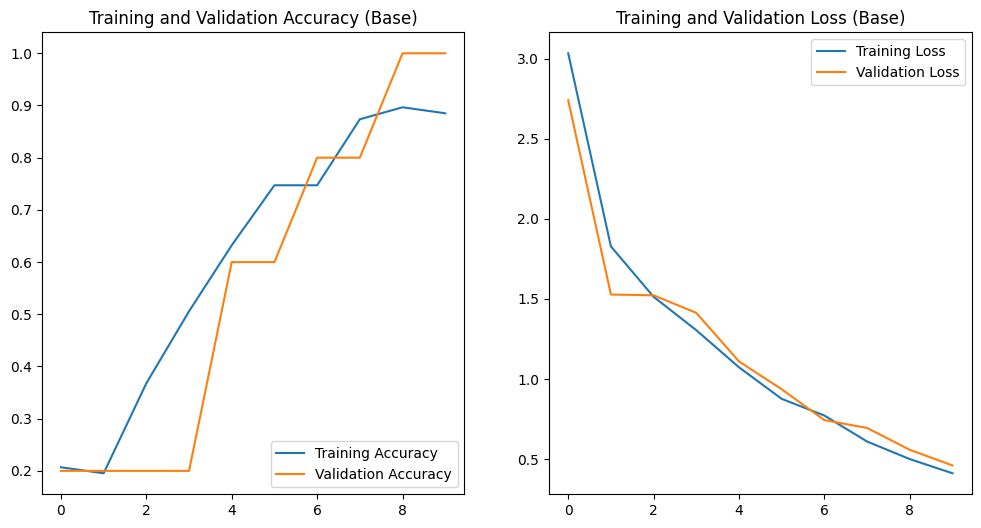

In [49]:
plot_accuracy_loss(history_base)

In [50]:
y_true, y_pred = eval_model_on_test(model_base, test_ds)

Predicting on Test Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step


Predicting on Test Data: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


In [51]:
print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of base model on test data: 65.62%
              precision    recall  f1-score   support

  bag_3_back       0.40      0.33      0.36         6
bag_2_inside       0.83      0.83      0.83         6
  bag_4_look       0.80      1.00      0.89         8
 bag_0_front       0.50      0.50      0.50         6
  bag_1_side       0.60      0.50      0.55         6

    accuracy                           0.66        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.64      0.66      0.64        32



,0,1,2,3,4
0,2,0,1,3,0
1,0,5,0,0,1
2,0,0,8,0,0
3,2,0,0,3,1
4,1,1,1,0,3
